In [29]:
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [36]:
# CONCATENATE ALL INTO ONE TXT FILE IN BKND_TXT
# THEN READ THAT FILE IN

cols = [1,2,4,5,6,7,8,9]

filepath = "/lustre19/expphy/volatile/clas12/users/erins/neutron-veto/d_6gev/6gev_txt/"
#neutron_names = glob(filepath + "goodn_jus_pCD_015*.txt")
neutron_names = glob(filepath + "goodn_jus_pCD_015*.txt")
n_arrays = [np.genfromtxt(f, invalid_raise=False) for f in neutron_names]
ndata = np.concatenate(n_arrays, axis=0)[0:47000,:]
# only 333 neutrons in e'p


#proton_names = glob(filepath + "badn_jus_pCD_015*.txt")
proton_names = glob(filepath + "badn_jus_pCD_015*.txt")
p_arrays = [np.genfromtxt(f, invalid_raise=False) for f in proton_names]
pdata = np.concatenate(p_arrays, axis=0)[0:47000,:]


ny = np.ones(len(ndata)) # neutrons - assigned 1
py = np.zeros(len(pdata)) # protons - assigned 0

print(np.shape(ndata))
print(np.shape(pdata))

myX = np.concatenate((ndata[:,1:],pdata[:,1:]),axis=0)
#myX = np.concatenate((ndata[:,cols],pdata[:,cols]),axis=0)
myX = np.nan_to_num(myX, nan=0)
myY = np.concatenate((ny,py),axis=0)
print(np.argwhere(np.isnan(myX)))
# number of good neutrons (pCDn): 261,475
# number of bad neutrons (pCDn): 476,958
# number of good neutrons (pFDn): 8510
# number of bad neutrons (pFDn):79338
# if no theta_pmiss cut (pCDn), 3269k good neutrons
# if no theta_pmiss cut (pCDn), 1.05M good neutrons


(3981, 8)
(3108, 12)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 7 and the array at index 1 has size 11

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    myX[1:],
    myY[1:],
    shuffle=True,
    test_size=0.5,
)

from sklearn.preprocessing import StandardScaler

"""sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)"""

clf = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, verbose=1)
#clf = RandomForestClassifier(max_depth=5, random_state=0)

clf.fit(X_train,y_train)

print("Accuracy:")
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

      Iter       Train Loss   Remaining Time 
         1           1.1842            7.74s
         2           1.0495            7.63s
         3           0.9550            7.59s
         4           0.8829            7.52s
         5           0.8290            7.44s
         6           0.7890            7.35s
         7           0.7565            7.27s
         8           0.7337            7.19s
         9           0.7149            7.10s
        10           0.6998            7.03s
        20           0.6431            6.25s
        30           0.6266            5.53s
        40           0.6167            4.78s
        50           0.6102            4.01s
        60           0.6028            3.23s
        70           0.5962            2.43s
        80           0.5908            1.63s
        90           0.5835            0.81s
       100           0.5776            0.00s
Accuracy:
0.8858273580288942
0.8687872340425532


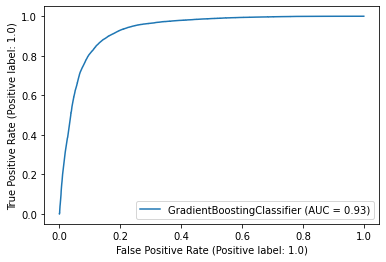

In [38]:
# ROC curve? illustrate tree application somehow
metrics.plot_roc_curve(clf, X_test, y_test)
plt.savefig("d2_accuracy.png")
# plot of accuracy or something

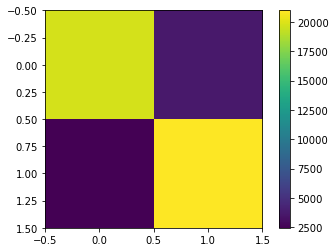

In [39]:
# confusion matrix
y_pred_test = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred_test)
plt.imshow(mat)
plt.colorbar()

In [40]:
import pandas as pd
#feature_list = ['num recon n','is_CND1 (bool)','is_CND2 (bool)','is_CND3 (bool)','num layers',
#                'num CND hits (event)','num CND ADCs (event)','num CND TDCs (event)',
#                'num CTOF ADCs (event)','num CTOF TDCs (event)','num CND clusters','pindex',
#                'sector','layer','component','energy','path','num CTOF hits','CTOF energy',
#                '4NN','corners','8NN','time','status','dedx','size','CTOF hit match',
#                'CTOF event energy','eN_angle','x','y','z']
feature_list = ['neutron energy',
                'CND layer multiplicity',#'z',                 
                'cluster size',#'beta',
                'CND nearby hits',
                'CND nearby energy',
                'CTOF nearby energy',
                'CTOF nearby hits',
                #'angle diff CVT 12',
                #'n phi','num particles','num neutrons'
                'is_CTOF',#'CTOF-CND sec',
                #'CND+CTOF'
                'is_CND1','is_CND2','is_CND3'
                ]
d = {'feature': feature_list, 'importance': clf.feature_importances_}
df = pd.DataFrame(data=d)
df.sort_values(by='importance', ascending=False)

,feature,importance
5,CTOF nearby energy,0.396334
6,CTOF nearby hits,0.166320
0,neutron energy,0.145068
8,is_CND1,0.077079
3,CND nearby hits,0.076190
7,is_CTOF,0.058163
1,CND layer multiplicity,0.053125
4,CND nearby energy,0.020827
2,cluster size,0.003436
10,is_CND3,0.002216


IndexError: index 8 is out of bounds for axis 1 with size 8

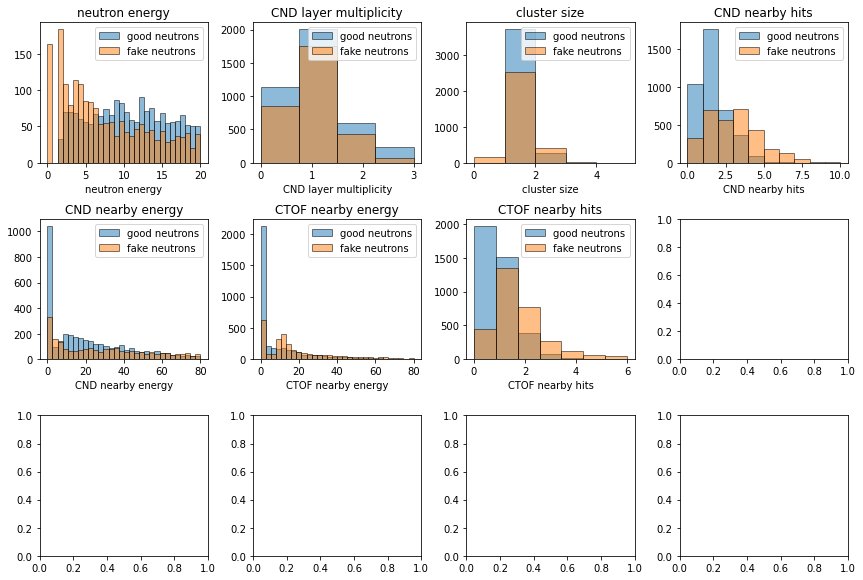

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.subplots_adjust(hspace=0.4)
"""for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.xlabel(feature_list[i])
    plt.title(feature_list[i])"""

highE = 80

plt.subplot(3,4,1)
plt.hist(ndata[:,1],bins=30,range=(0,20),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,1],bins=30,range=(0,20),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[0])
plt.title(feature_list[0])
plt.legend()
plt.subplot(3,4,2)
plt.hist(ndata[:,2],bins=4,range=(0,3),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,2],bins=4,range=(0,3),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[1])
plt.title(feature_list[1])
plt.legend()
plt.subplot(3,4,3)
plt.hist(ndata[:,3],bins=5,range=(0,5),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,3],bins=5,range=(0,5),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[2])
plt.title(feature_list[2])
plt.legend()
plt.subplot(3,4,4)
plt.hist(ndata[:,4],bins=10,range=(0,10),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,4],bins=10,range=(0,10),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[3])
plt.title(feature_list[3])
plt.legend()
plt.subplot(3,4,5)
plt.hist(ndata[:,5],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,5],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[4])
plt.title(feature_list[4])
plt.legend()
plt.subplot(3,4,6)
plt.hist(ndata[:,6],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,6],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[5])
plt.title(feature_list[5])
plt.legend()
plt.subplot(3,4,7)
plt.hist(ndata[:,7],bins=7,range=(0,6),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,7],bins=7,range=(0,6),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[6])
plt.title(feature_list[6])
plt.legend()
"""plt.subplot(2,4,8)
plt.hist(ndata[:,8],bins=50,range=(-60,360),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,8],bins=50,range=(-60,360),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[7])
plt.title(feature_list[7])"""
"""plt.subplot(3,4,8)
plt.hist(ndata[:,8],bins=50,range=(-180,180),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,8],bins=50,range=(-180,180),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[7])
plt.title(feature_list[7])"""
plt.subplot(3,4,8)
plt.hist(ndata[:,8],bins=3,range=(-1,1),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,8],bins=3,range=(-1,1),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[7])
plt.title(feature_list[7])
plt.legend()
plt.subplot(3,4,9)
plt.hist(ndata[:,9],bins=3,range=(0,2),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,9],bins=3,range=(0,2),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[8])
plt.title(feature_list[8])
plt.legend()
plt.subplot(3,4,10)
plt.hist(ndata[:,10],bins=3,range=(0,2),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,10],bins=3,range=(0,2),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[9])
plt.title(feature_list[9])
plt.legend()
plt.subplot(3,4,11)
plt.hist(ndata[:,11],bins=3,range=(0,2),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,11],bins=3,range=(0,2),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[10])
plt.title(feature_list[10])
plt.legend()
"""plt.subplot(3,4,10)
plt.hist(ndata[:,10],bins=3,range=(0,2),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,10],bins=3,range=(0,2),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[9])
plt.title(feature_list[9])
plt.legend()"""



#plt.subplot(2,4,8)
#plt.axis("off")

plt.savefig("d2_features.png")

# TEST ON SIMULATION

In [155]:
filepath = "/w/hallb-scshelf2102/clas/clase2/erins/repos/neutron-veto/Simulation_eN/"
sim_neutron_names = glob(filepath + "eN_bknd/bknd_txt/good_neutrons_*.txt")
sim_n_arrays = [np.genfromtxt(f, invalid_raise=False) for f in sim_neutron_names]
sim_ndata = np.concatenate(sim_n_arrays, axis=0)[0:274000,:]
# only 333 neutrons in e'p


sim_proton_names = glob(filepath + "eN_bknd/bknd_txt/fake_neutrons_*.txt")
sim_p_arrays = [np.genfromtxt(f, invalid_raise=False) for f in sim_proton_names]
sim_pdata = np.concatenate(sim_p_arrays, axis=0)[0:274000,:]

sim_ny = np.zeros(len(sim_ndata)) # neutrons - assigned 0
sim_py = np.ones(len(sim_pdata)) # protons - assigned 1

print(np.shape(sim_ndata))
print(np.shape(sim_pdata))

sim_myX = np.concatenate((sim_ndata[:,1:],sim_pdata[:,1:]),axis=0)
sim_myX = np.nan_to_num(sim_myX, nan=0)
sim_myY = np.concatenate((sim_ny,sim_py),axis=0)

print(clf.score(sim_myX,sim_myY))

(34059, 9)
(38036, 9)


ValueError: X has 8 features, but DecisionTreeRegressor is expecting 11 features as input.

# TEST ON pFD

In [ ]:
filepath = "/lustre19/expphy/volatile/clas12/users/erins/neutron-veto/d_2gev2gev_txt/"
fd_neutron_names = glob(filepath + "goodn_jus_pFD_015*.txt")
fd_n_arrays = [np.genfromtxt(f, invalid_raise=False) for f in fd_neutron_names]
fd_ndata = np.concatenate(fd_n_arrays, axis=0)[0:274000,:]
# only 333 neutrons in e'p


fd_proton_names = glob(filepath + "badn_jus_pFD_015*.txt")
fd_p_arrays = [np.genfromtxt(f, invalid_raise=False) for f in fd_proton_names]
fd_pdata = np.concatenate(fd_p_arrays, axis=0)[0:274000,:]

fd_ny = np.zeros(len(fd_ndata)) # neutrons - assigned 0
fd_py = np.ones(len(fd_pdata)) # protons - assigned 1

print(np.shape(fd_ndata))
print(np.shape(fd_pdata))

fd_myX = np.concatenate((fd_ndata,fd_pdata),axis=0)
fd_myX = np.nan_to_num(fd_myX, nan=0)
fd_myY = np.concatenate((fd_ny,fd_py),axis=0)

print(clf.score(fd_myX,fd_myY))

# Test on 6 GeV

In [ ]:
filepath = "/w/hallb-scshelf2102/clas/clase2/erins/repos/neutron-veto/d_6gev/6gev_txt/"
fd_neutron_names = glob(filepath + "goodn_jus_pCD_015*.txt")
fd_n_arrays = [np.genfromtxt(f, invalid_raise=False) for f in fd_neutron_names]
fd_ndata = np.concatenate(fd_n_arrays, axis=0)[0:274000,:]
# only 333 neutrons in e'p


fd_proton_names = glob(filepath + "badn_jus_pCD_015*.txt")
fd_p_arrays = [np.genfromtxt(f, invalid_raise=False) for f in fd_proton_names]
fd_pdata = np.concatenate(fd_p_arrays, axis=0)[0:274000,:]

fd_ny = np.zeros(len(fd_ndata)) # neutrons - assigned 0
fd_py = np.ones(len(fd_pdata)) # protons - assigned 1

print(np.shape(fd_ndata))
print(np.shape(fd_pdata))

fd_myX = np.concatenate((fd_ndata,fd_pdata),axis=0)
fd_myX = np.nan_to_num(fd_myX, nan=0)
fd_myY = np.concatenate((fd_ny,fd_py),axis=0)

print(clf.score(fd_myX,fd_myY))